In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

In [2]:
!unzip '/content/drive/MyDrive/cityscape_dataset.zip'


Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: citysca

In [3]:
train_path = glob('/content/cityscapes_data/cityscapes_data/train/*')
valid_path = glob('/content/cityscapes_data/cityscapes_data/val/*')

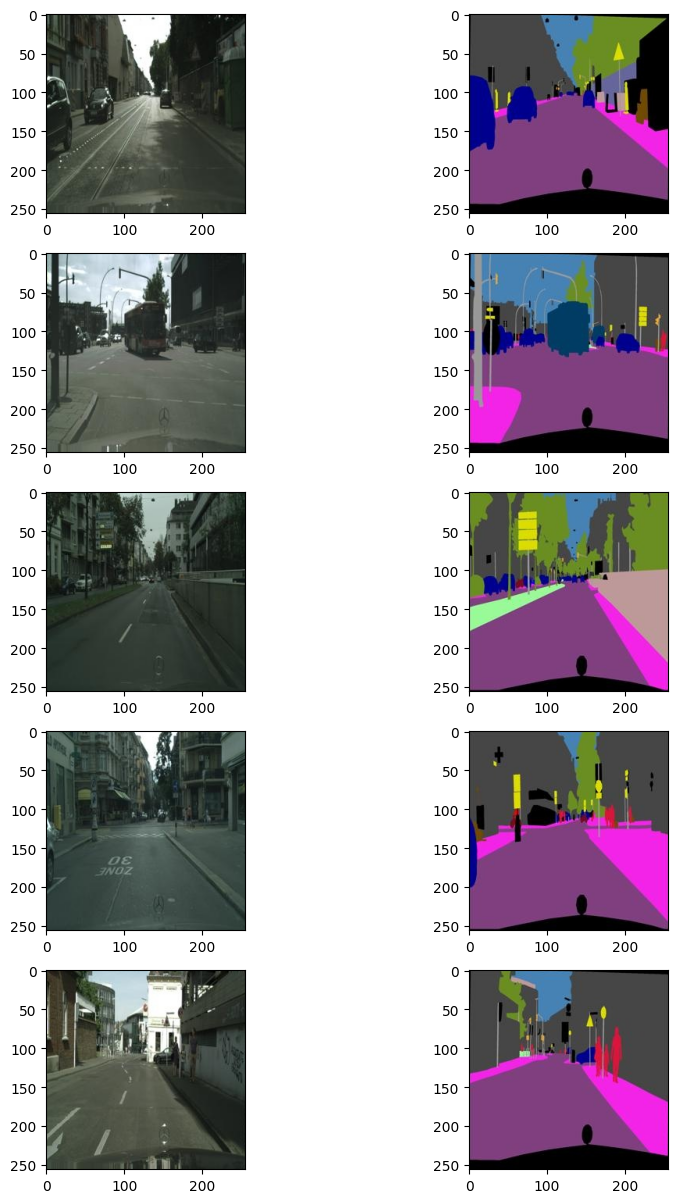

In [4]:
fig, ax = plt.subplots(5,2,figsize=(10,15))
for i in range(5):
  img = plt.imread(train_path[i])
  ax[i][0].imshow(img[:,:256])
  ax[i][1].imshow(img[:,256:])

In [5]:
train_dataset = []
validation_dataset = []

In [6]:
class MyDataset(Dataset):

    def __init__(self, images_path ,transform_img=None ,transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):

        img = plt.imread(self.images_path[idx])
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [7]:
mytransformsImage = transform.Compose(
    [
        transform.ToTensor(),
        #transform.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transform.RandomHorizontalFlip(p=0.9)
    ]
)

mytransformsLabel = transform.Compose(
    [
        transform.ToTensor(),
    ]
)


In [ ]:
# train dataset
traindata = MyDataset(train_path, mytransformsImage, mytransformsLabel)
# val dataset
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)

In [ ]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
vaild_loader = DataLoader(valdata,1)


In [ ]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))

    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Convblock(nn.Module):

      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )


      def forward(self,x):
        x = self.convblock(x)
        return x

In [ ]:
class UNet(nn.Module):

    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain

    def forward(self,x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)

        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out

    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)


In [ ]:
# initializing the model
model = UNet(3).float().to(device)


In [ ]:
lr = 0.01
epochs = 30

# Choosing the loss function to be Mean Square Error Loss
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []


In [ ]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))

    for img,label in tqdm(vaild_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(vaild_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))


Output hidden; open in https://colab.research.google.com to view.

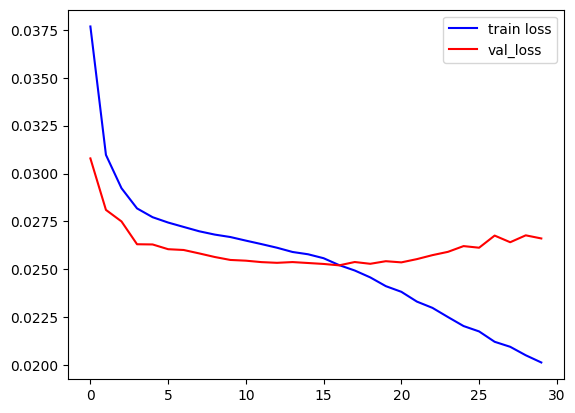

In [ ]:
plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    plt.show()

In [ ]:
c = 0
for img,label in (vaild_loader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        show(img,output,label)
        if c>20:
            break
        c+=1


Output hidden; open in https://colab.research.google.com to view.

#Pix2Pix

In [ ]:
# Creating Dataset Class for Cityscapes (Pix2Pix)

class CityscapesDataset(Dataset):

    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.files = sorted(os.listdir(self.data_dir))
        self.image_paths = []
        self.label_paths = []


    def __len__(self):

        return len(self.files)


    def __getitem__(self, idx):

        image_path = os.path.join(self.data_dir, self.files[idx])
        image = Image.open(image_path).convert("RGB")

        width, height = image.size
        real_image = image.crop((0, 0, width // 2, height))
        segmented_image = image.crop((width //2, 0, width, height))

        if self.transform:
            real_image = self.transform(real_image)
            segmented_image = self.transform(segmented_image)

        return segmented_image, real_image

In [ ]:
# Loading Cityscapes Pix2Pix Dataset

SIZE = 256
batch_size = 32
root_dir = "/content/cityscapes_data"
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

data_transforms = transform.Compose([
    transform.Resize((SIZE, SIZE)),
    transform.ToTensor(),
    transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                     # normalizing range (-1, 1)
])

train_dataset = CityscapesDataset(train_dir, transform=data_transforms)
val_dataset = CityscapesDataset(val_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

In [ ]:
# Displaying 3 Sample Pairs

def display_sample_pairs(dataset, num_pairs=10, title="Sample Pairs"):

    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))
    fig.suptitle(title, fontsize=16)

    for i in range(num_pairs):
        segmented_image, real_image = dataset[i]
        segmented_image = segmented_image.permute(1, 2, 0) * 0.5 + 0.5          # denormalize for visualization
        real_image = real_image.permute(1, 2, 0) * 0.5 + 0.5                    # denormalize for visualization

        axes[i, 0].imshow(segmented_image)
        axes[i, 0].set_title("Input: Segmented Image")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(real_image)
        axes[i, 1].set_title("Target: Real Image")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_pairs(train_dataset, num_pairs=3, title="Sample Pairs from Train Dataset")
display_sample_pairs(val_dataset, num_pairs=3, title="Sample Pairs from Val Dataset")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Defining Discriminator Class

class Discriminator(nn.Module):

    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        # helper function to construct layers quickly
        def conv_block(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=4, stride=stride, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        # due to concatenated input of segmented+real, in_channels=in_channels*2
        self.model = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1),     # C64, no BatchNorm
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(64, 128, stride=2),                                        # C128
            conv_block(128, 256, stride=2),                                       # C256
            conv_block(256, 512, stride=1),                                       # C512 (stride 1 for 70x70 patches)

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),                # Final layer
            nn.Sigmoid()
        )


    def forward(self, x, y):

        concatenated = torch.cat([x, y], dim=1)
        verdict = self.model(concatenated)

        return verdict

In [ ]:
# Defining Generator Class (via DownSample and UpSample Classes)

class DownSample(nn.Module):

    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(DownSample, self).__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not(apply_batchnorm))]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.down = nn.Sequential(*layers)


    def forward(self, x):

        return self.down(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(UpSample, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        self.up = nn.Sequential(*layers)


    def forward(self, x, skip):

        x = self.up(x)
        x = torch.cat([x, skip], dim=1)                                         # skip connection
        return x


class Generator(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        # Encoder (DownSampling)
        self.down1 = DownSample(in_channels, 64, apply_batchnorm=False)         # C64
        self.down2 = DownSample(64, 128)                                        # C128
        self.down3 = DownSample(128, 256)                                       # C256
        self.down4 = DownSample(256, 512)                                       # C512
        self.down5 = DownSample(512, 512)                                       # C512
        self.down6 = DownSample(512, 512)                                       # C512
        self.down7 = DownSample(512, 512)                                       # C512
        self.down8 = DownSample(512, 512)                                       # C512

        # Decoder (Upsampling)
        self.up1 = UpSample(512, 512, apply_dropout=True)                       # CD512
        self.up2 = UpSample(1024, 512, apply_dropout=True)                      # CD1024
        self.up3 = UpSample(1024, 512, apply_dropout=True)                      # CD1024
        self.up4 = UpSample(1024, 512)                                          # C1024
        self.up5 = UpSample(1024, 256)                                          # C1024
        self.up6 = UpSample(512, 128)                                           # C512
        self.up7 = UpSample(256, 64)                                            # C256

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )


    def forward(self, x):

        # Encoder forward
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Decoder forward + skip connections (U-Net)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [ ]:
 #Defining Pix2Pix Model Class and Cost Functions

class Pix2Pix(nn.Module):

    def __init__(self, generator, discriminator):
        super(Pix2Pix, self).__init__()

        self.generator = generator
        self.discriminator = discriminator
        self.criterion_gan = nn.BCEWithLogitsLoss()
        self.criterion_l1 = nn.L1Loss()


    def generator_loss(self, fake_output, fake_target, real_target, lambda_l1=100):

        adversarial_loss = self.criterion_gan(fake_output, torch.ones_like(fake_output, device=fake_output.device))
        l1_loss = self.criterion_l1(fake_target, real_target)

        total_loss = adversarial_loss + lambda_l1 * l1_loss
        return total_loss


    def discriminator_loss(self, real_output, fake_output):

        real_loss = self.criterion_gan(real_output, torch.ones_like(real_output, device=real_output.device))
        fake_loss = self.criterion_gan(fake_output, torch.zeros_like(fake_output, device=fake_output.device))

        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [ ]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}.")

Current device: cuda.


In [ ]:
# Instantiating Pix2Pix Model

generator = Generator().to(device)
discriminator = Discriminator().to(device)
pix2pix = Pix2Pix(generator, discriminator).to(device)

print(pix2pix)

Pix2Pix(
  (generator): Generator(
    (down1): DownSample(
      (down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (down2): DownSample(
      (down): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (down3): DownSample(
      (down): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (down4): DownSample(
      (down): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

In [ ]:
# Defining Training Tools

def train_pix2pix(pix2pix_model, train_loader, val_loader, epochs, lambda_l1, display_interval):

    start_time = time.time()
    train_g_losses, train_d_losses = [], []
    val_g_losses, val_d_losses = [], []

    for epoch in range(epochs):

        # training
        pix2pix_model.train()
        train_g_loss, train_d_loss = 0.0, 0.0

        for idx, (segmented_images, real_images) in enumerate(tqdm(train_loader, desc=f"Training {epoch+1}/{epochs}")):
            segmented_images = segmented_images.to(device)
            real_images = real_images.to(device)

            # train model discriminator
            d_optimizer.zero_grad()
            fake_images = pix2pix_model.generator(segmented_images)
            real_output = pix2pix_model.discriminator(segmented_images, real_images)
            fake_output = pix2pix_model.discriminator(segmented_images, fake_images)
            d_loss = pix2pix_model.discriminator_loss(real_output, fake_output)
            d_loss.backward()
            d_optimizer.step()

            # train model generator
            g_optimizer.zero_grad()
            fake_images = pix2pix_model.generator(segmented_images)
            fake_output = pix2pix_model.discriminator(segmented_images, fake_images)
            g_loss = pix2pix_model.generator_loss(fake_output, fake_images, real_images, lambda_l1)
            g_loss.backward()
            g_optimizer.step()

            train_d_loss += d_loss.item()
            train_g_loss += g_loss.item()

        # average train loss per epoch
        train_d_losses.append(train_d_loss / len(train_loader))
        train_g_losses.append(train_g_loss / len(train_loader))

        # validating
        pix2pix_model.eval()
        val_g_loss, val_d_loss = 0.0, 0.0

        with torch.no_grad():
            for idx, (segmented_images, real_images) in enumerate(tqdm(val_loader, desc=f"Validating {epoch+1}/{epochs}")):
                segmented_images = segmented_images.to(device)
                real_images = real_images.to(device)

                fake_images = pix2pix_model.generator(segmented_images)
                real_output = pix2pix_model.discriminator(segmented_images, real_images)
                fake_output = pix2pix_model.discriminator(segmented_images, fake_images)

                d_loss = pix2pix_model.discriminator_loss(real_output, fake_output)
                g_loss = pix2pix_model.generator_loss(fake_output, fake_images, real_images, lambda_l1)

                val_d_loss += d_loss.item()
                val_g_loss += g_loss.item()

        # average val loss per epoch
        val_d_losses.append(val_d_loss / len(val_loader))
        val_g_losses.append(val_g_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs} | G Train Loss: {train_g_losses[-1]:.4f} | D Train Loss: {train_d_losses[-1]:.4f} | G Val Loss: {val_g_losses[-1]:.4f} | D Val Loss: {val_d_losses[-1]:.4f}")

        # display sample results after each interval
        if (epoch + 1) % display_interval == 0 or (epoch + 1) == epochs:
            display_generated_samples(pix2pix_model, train_loader, num_samples=3)

    print(f"Training Completed in {time.time() - start_time:.2f} seconds.")
    return train_g_losses, train_d_losses, val_g_losses, val_d_losses


def display_generated_samples(model, loader, num_samples=10, title="Generated Samples"):

    model.eval()
    with torch.no_grad():
        segmented_images, real_images = next(iter(loader))
        segmented_images = segmented_images[:num_samples].to(device)
        real_images = real_images[:num_samples].to(device)

        fake_images = model.generator(segmented_images)

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(title, fontsize=16)

        for i in range(num_samples):
            axes[i, 0].imshow((segmented_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)         # denormalizing
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            axes[i, 1].imshow((real_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)              # denormalizing
            axes[i, 1].set_title("Target Image")
            axes[i, 1].axis('off')
            axes[i, 2].imshow((fake_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)              # denormalizing
            axes[i, 2].set_title("Generated Image")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
# Training Pix2Pix Model

num_epochs = 50
learning_rate = 2e-4
lambda_l1 = 100
display_interval = 10

g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

train_g_losses, train_d_losses, val_g_losses, val_d_losses = train_pix2pix(pix2pix, train_loader, val_loader, num_epochs, lambda_l1, display_interval)

Output hidden; open in https://colab.research.google.com to view.

#SegNet

In [8]:
# Creating Dataset Class for Cityscapes

class CityscapesDataset(Dataset):

    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.files = sorted(os.listdir(self.data_dir))
        self.image_paths = []
        self.label_paths = []


    def __len__(self):

        return len(self.files)


    def __getitem__(self, idx):

        image_path = os.path.join(self.data_dir, self.files[idx])
        image = Image.open(image_path).convert("RGB")

        width, height = image.size
        real_image = image.crop((0, 0, width // 2, height))
        segmented_image = image.crop((width //2, 0, width, height))

        if self.transform:
            real_image = self.transform(real_image)
            segmented_image = self.transform(segmented_image)

        return segmented_image, real_image

In [9]:
# Loading Cityscapes Dataset

SIZE = 256
batch_size = 32
root_dir = "/content/cityscapes_data/cityscapes_data"
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

data_transforms = transform.Compose([
    transform.Resize((SIZE, SIZE)),
    transform.ToTensor(),
    transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                     # normalizing range (-1, 1)
])

train_dataset = CityscapesDataset(train_dir, transform=data_transforms)
val_dataset = CityscapesDataset(val_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

In [10]:
# Displaying 3 Sample Pairs

def display_sample_pairs(dataset, num_pairs=10, title="Sample Pairs"):

    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))
    fig.suptitle(title, fontsize=16)

    for i in range(num_pairs):
        segmented_image, real_image = dataset[i]
        segmented_image = segmented_image.permute(1, 2, 0) * 0.5 + 0.5          # denormalize for visualization
        real_image = real_image.permute(1, 2, 0) * 0.5 + 0.5                    # denormalize for visualization

        axes[i, 0].imshow(segmented_image)
        axes[i, 0].set_title("Input: Segmented Image")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(real_image)
        axes[i, 1].set_title("Target: Real Image")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_pairs(train_dataset, num_pairs=3, title="Sample Pairs from Train Dataset")
display_sample_pairs(val_dataset, num_pairs=3, title="Sample Pairs from Val Dataset")

Output hidden; open in https://colab.research.google.com to view.

In [11]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}.")

Current device: cuda.


In [12]:
# Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        x = self.block(x)
        pooled, indices = self.pool(x)
        return pooled, indices, x.size()

# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, indices, output_size):
        x = self.unpool(x, indices, output_size=output_size)
        return self.block(x)

# SegNet Model
class SegNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=20):
        super(SegNet, self).__init__()
        self.encoder1 = EncoderBlock(input_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)
        self.decoder5 = DecoderBlock(512, 512)
        self.decoder4 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder1 = DecoderBlock(64, num_classes)

    def forward(self, x):
        e1, ind1, size1 = self.encoder1(x)
        e2, ind2, size2 = self.encoder2(e1)
        e3, ind3, size3 = self.encoder3(e2)
        e4, ind4, size4 = self.encoder4(e3)
        e5, ind5, size5 = self.encoder5(e4)
        d5 = self.decoder5(e5, ind5, size5)
        d4 = self.decoder4(d5, ind4, size4)
        d3 = self.decoder3(d4, ind3, size3)
        d2 = self.decoder2(d3, ind2, size2)
        d1 = self.decoder1(d2, ind1, size1)
        return d1


In [13]:
import time

# Loss function
criterion = nn.CrossEntropyLoss()
# Define your SegNet model
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        # Define layers here (e.g., Conv2d, MaxPool2d, etc.)

    def forward(self, x):
        # Define the forward pass
        return x

# Initialize the model and optimizer
segnet = SegNet().to(device)
segnet_optimizer = optim.Adam(segnet.parameters(), lr=1e-3)

# Training function
def train_segnet(segnet_model, train_loader, val_loader, epochs, display_interval):
    segnet_model = segnet_model.to(device)
    start_time = time.time()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        segnet_model.train()
        train_loss = 0.0

        # Training loop
        for images, masks in tqdm(train_loader, desc=f"Training {epoch + 1}/{epochs}"):
            images = images.to(device)
            masks = masks.to(device)

            segnet_optimizer.zero_grad()
            outputs = segnet_model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            segnet_optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        segnet_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Validating {epoch + 1}/{epochs}"):
                images = images.to(device)
                masks = masks.to(device)

                outputs = segnet_model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

        # Visualize predictions every interval
        if (epoch + 1) % display_interval == 0 or (epoch + 1) == epochs:
            display_segmentation_results(segnet_model, train_loader, num_samples=3)

    print(f"Training Completed in {time.time() - start_time:.2f} seconds.")
    return train_losses, val_losses


# Visualization function
def display_segmentation_results(model, loader, num_samples=5, title="Segmentation Results"):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(loader))
        images = images[:num_samples].to(device)
        masks = masks[:num_samples]

        predictions = model(images).argmax(dim=1).cpu()

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(title, fontsize=16)

        for i in range(num_samples):
            axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            axes[i, 1].imshow(masks[i].numpy())
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis('off')
            axes[i, 2].imshow(predictions[i].numpy())
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()


ValueError: optimizer got an empty parameter list

In [ ]:
# Parameters
num_epochs = 50
learning_rate = 1e-3
display_interval = 10

# Define optimizer and loss function
optimizer = optim.Adam(SegNet.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # Assuming segmentation classes are encoded as class indices

# Train the SegNet model
train_losses, val_losses = train_segnet(SegNet, train_loader, val_loader, num_epochs, optimizer, criterion, display_interval)
# Visualize results on validation set
display_segmentation_results(SegNet, val_loader, num_samples=5)

In [ ]:
# Define hyperparameters
num_epochs = 50
learning_rate = 1e-3
display_interval = 10

# Optimizer for SegNet
segnet_optimizer = optim.Adam(segnet.parameters(), lr=learning_rate)

# Training Function
def train_segnet(segnet_model, train_loader, val_loader, epochs, optimizer, display_interval):
    segnet_model = segnet_model.to(device)
    criterion = nn.CrossEntropyLoss()  # Loss function for semantic segmentation
    start_time = time.time()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        segnet_model.train()
        train_loss = 0.0

        # Training loop
        for images, masks in tqdm(train_loader, desc=f"Training {epoch + 1}/{epochs}"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = segnet_model(images)

            # Reshape outputs and masks for loss calculation
            outputs = outputs.permute(0, 2, 3, 1).reshape(-1, outputs.size(1))
            masks = masks.view(-1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        segnet_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Validating {epoch + 1}/{epochs}"):
                images = images.to(device)
                masks = masks.to(device)

                outputs = segnet_model(images)

                # Reshape outputs and masks for loss calculation
                outputs = outputs.permute(0, 2, 3, 1).reshape(-1, outputs.size(1))
                masks = masks.view(-1)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

        # Visualize predictions every interval
        if (epoch + 1) % display_interval == 0 or (epoch + 1) == epochs:
            display_segmentation_results(segnet_model, train_loader, num_samples=3)

    print(f"Training Completed in {time.time() - start_time:.2f} seconds.")
    return train_losses, val_losses

# Visualization Function
def display_segmentation_results(model, loader, num_samples=5, title="Segmentation Results"):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(loader))
        images = images[:num_samples].to(device)
        masks = masks[:num_samples].to(device)

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class indices

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(title, fontsize=16)

        for i in range(num_samples):
            axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(predictions[i].cpu().numpy(), cmap="gray")
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.show()

# Training the model
train_losses, val_losses = train_segnet(segnet, train_loader, val_loader, num_epochs, segnet_optimizer, display_interval)
